# Recommendation

Here we will extract some information that will help to recommend certain movies to see, based on the characters you like; which characters are most relevant and if they are good connected to others. The analyse consists of determine:
- Is peson "a" good connect to other characters
- In which movies is my favorte character
- Most important character

In [1]:
# Imports
from neo4j import GraphDatabase, basic_auth
import pandas as pd
from vis_class import vis_class

In [2]:
# DB connection
#uri = "bolt://localhost:7687"
#user = "neo4j"
#password = "neo4j"

login = open("Login.txt", "r")
uri = login.readline()
user = login.readline()
password = "RgC0_tAy1f8T_-_d1FnszgwXo1VafPO7h5gme7fJHlI"
login.close()

driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))
session = driver.session(database="neo4j")

visualizer = vis_class()

<IPython.core.display.Javascript object>

Vis class was created


## Is peson "a" good connect to other characters

We will asume that two nodes are good connected if there are at least 100 paths between them, and this paths are no longer than 5 nodes between these 2.

In [3]:
ch1='C-3PO'
ch2='OBI-WAN'
paths = "MATCH p=(ch1)-[*..5]->(ch2) WHERE ch1.name='"+ch1+"' AND ch2.name='"+ch2+"'RETURN count(p)"
n_paths = session.run(paths).single().value()
if n_paths > 100:
    print('%s is good connected to %s, with %d connections between them.'% (ch1, ch2, n_paths))
else:
    print('%s is not good connected to %s, with just %d connections between them.'% (ch1, ch2, n_paths))

C-3PO is good connected to OBI-WAN, with 109 connections between them.


We can visualize all the paths between them:

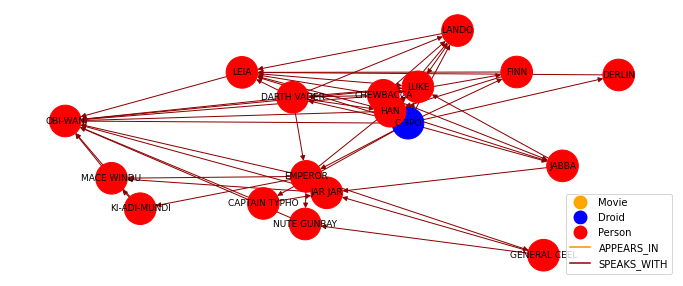

In [4]:
paths = "MATCH p=(ch1)-[*..5]->(ch2) WHERE ch1.name='"+ch1+"' AND ch2.name='"+ch2+"'RETURN p"
vis_class.power_drawGraph(driver, paths, node_size=1000, font_size=9, height=5)

![title](img/pathsBetween.png)

## In which movies is my favorte character

In [5]:
myFavChar = 'OBI-WAN'
movies = "MATCH p=(n)-[r:APPEARS_IN]->(m:Movie) WHERE n.name='" + myFavChar + '''' RETURN n AS source_node, 
            id(n) AS source_id,
            r,
            m AS target_node,
            id(m) As target_id'''
#vis_class.power_drawGraph(driver, movies, font_size=8, width=17, height=6)
vis_class.drawGraph(session, {'Movie':'name', 'Person':'name', 'Droid':'name'}, movies)

## Who is the most important character

We will determine the importance of a character based on it's centrality degree. This is the simplest centrality algorithm and it measures the number of incoming and outgoing relationships from a node.

According to this, the degree centrality will help us to know who is the most important character of the saga.

In [6]:
most_important = '''
    MATCH (ch)
    WHERE ch:Person OR ch:Droid
    CALL {
        WITH ch MATCH p=(ch)-->() RETURN count(p) AS occurrences
        UNION
        WITH ch MATCH p=(ch)<--() RETURN count(p) AS occurrences
    }
    WITH ch, collect(occurrences) AS occ
    WITH ch, occ[0] AS Outgoing, occ[1] AS Incoming, abs(occ[0]-occ[1]) AS Balance, occ[0]+occ[1] AS Total
    WHERE Total IS NOT NULL
    RETURN ch.name,  Outgoing, Incoming, Balance, Total
    ORDER BY Total DESC, Balance
'''
results = session.read_transaction(
        lambda tx: tx.run(most_important).data())
df = pd.DataFrame(results)
df.head()

,ch.name,Outgoing,Incoming,Balance,Total
0,ANAKIN,46,0,46,46
1,OBI-WAN,21,22,1,43
2,C-3PO,33,10,23,43
3,PADME,14,23,9,37
4,LUKE,14,17,3,31


We can see that Anakin has the highest degree with 46 relations, so we could determine that he is the most important character in the saga. However, Obi-Wan is the one with best balance between incoming and outgoing relations.

In [7]:
# Close all connections
driver.close()
session.close()
drive = None
session = None